In [1]:
# IMPORT CODE 
import os 
import cv2
import numpy as np
import pickle

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import *
from sklearn.model_selection import RandomizedSearchCV
from IPython import display
from PIL import Image


def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks.
  Args:
    a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
      (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
      image.
  """
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display.display(Image.fromarray(a))

def load_data(location, labels, metric):
    fv_list = os.listdir(location)
    fv_nb = len(fv_list)

    with open(location + fv_list[0], "rb") as handle: 
        fv0 = pickle.load(handle)

    with open(labels, "rb") as handle: 
        labels = pickle.load(handle)

    print("Number of vectors: " + str(fv_nb) + " of length " + str(len(fv0)))

    data_x = np.zeros(shape=(fv_nb, len(fv0)))
    data_y = np.zeros(shape=(fv_nb,))

    for i, fv_filename in enumerate(fv_list): 
        with open(location + fv_filename, "rb") as handle: 
            fv = pickle.load(handle)
        
        fid = fv_filename.split(".")[0]

        data_y[i] = 0
        if metric in labels[fid]: 
            data_y[i] = labels[fid][metric] 

        data_x[i] = fv

    return data_x, data_y, fv_list

In [2]:
DATA_FOLDER = "/home/tim/data/feature_vector_dataset/"

LABELS = DATA_FOLDER + "qualities_v2.pkl"
metric = "lqm"

train_x, train_y, train_names = load_data(DATA_FOLDER + "train/", LABELS, metric)
test_x, test_y, test_names = load_data(DATA_FOLDER + "test/", LABELS, metric)

Number of vectors: 12000 of length 192
Number of vectors: 1200 of length 192


In [3]:

#IMAGE_FOLDER = "D:/NIST datasets/SD 302/sd302e/images/latent/png/"
#image = cv2.imread(IMAGE_FOLDER + train_names[idx].split(".")[0] + ".png", 0)

#cv2.imshow("asd", image)
#cv2.waitKey(0)

In [4]:
import pickle
regr = MLPRegressor(verbose=True, alpha=0.0001, random_state=2, max_iter=500, solver="adam")
regr.fit(train_x, train_y)

predictions = np.clip(regr.predict(test_x), 0, 100)
train_predictions = np.clip(regr.predict(train_x), 0, 100)

print("train MSE", mean_squared_error(train_y, train_predictions))
print("test MSE", mean_squared_error(test_y, predictions))

print("train MAE", mean_absolute_error(train_y, train_predictions))
print("test MAE", mean_absolute_error(test_y, predictions))

print("train R2", r2_score(train_y, train_predictions))
print("test R2", r2_score(test_y, predictions))

with open("nn_model.pkl", "wb") as handle: 
    pickle.dump(regr, handle)

Iteration 1, loss = 26512.87866412
Iteration 2, loss = 328.75106981
Iteration 3, loss = 209.27027989
Iteration 4, loss = 155.22234738
Iteration 5, loss = 110.83192618
Iteration 6, loss = 91.32859547
Iteration 7, loss = 83.55203695
Iteration 8, loss = 77.38712596
Iteration 9, loss = 73.33474180
Iteration 10, loss = 70.52235685
Iteration 11, loss = 68.14661945
Iteration 12, loss = 66.22255465
Iteration 13, loss = 64.12633847
Iteration 14, loss = 62.09816264
Iteration 15, loss = 60.70479199
Iteration 16, loss = 58.44126063
Iteration 17, loss = 56.82195249
Iteration 18, loss = 56.31218877
Iteration 19, loss = 54.93328539
Iteration 20, loss = 54.31438571
Iteration 21, loss = 54.00350851
Iteration 22, loss = 53.63055502
Iteration 23, loss = 52.67723149
Iteration 24, loss = 52.23508000
Iteration 25, loss = 51.38942733
Iteration 26, loss = 51.86602989
Iteration 27, loss = 51.19554725
Iteration 28, loss = 50.59603077
Iteration 29, loss = 50.30368010
Iteration 30, loss = 49.73647990
Iteration 31

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


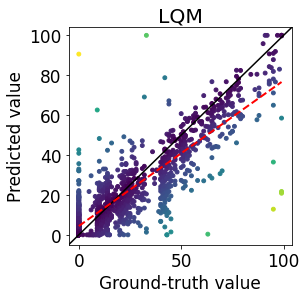

In [5]:
import matplotlib
from matplotlib import pyplot as plt

IMAGE_FOLDER = "/home/tim/data/SD301/images/latent/png/"

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

args = np.argsort(test_y)

sorted_gt = test_y[args]
sorted_p = predictions[args]
tn = np.array(test_names)[args]
diffs = sorted_p - sorted_gt


model = "LQM"
f = plt.figure(1, figsize=(4,4))
plt.axline((0, 0), (100, 100), color="black")
plt.xlabel("Ground-truth value")
plt.ylabel("Predicted value")
plt.scatter(sorted_gt, sorted_p, c=np.abs(diffs), s=15, cmap="viridis")
plt.title(model)
plt.xlim([-5, sorted_gt.max()+5])
plt.ylim([-5, sorted_gt.max()+5]) #sorted_p.max()+5])


m, b = np.polyfit(sorted_gt, sorted_p, 1)
plt.plot(sorted_gt, m*sorted_gt + b, color="red", linestyle='dashed', linewidth=2)


plt.show()

f.savefig(model + "_dashed.pdf", bbox_inches='tight')

In [6]:
IMAGE_FOLDER = "/home/tim/data/SD301/images/latent/png/"

print("Predicting Verifinger scores: ")
for i in range(300, 350): 
    image = cv2.imread(IMAGE_FOLDER + test_names[i].split(".")[0] + ".png", 0)
    image = cv2.resize(image, (512, 512))
    
    image = cv2.copyMakeBorder(image, 0, 50, 0, 0, cv2.BORDER_CONSTANT, value=0)
    image = cv2.putText(image, "Predicted: " + str(round(predictions[i], 2)), (5, 532), cv2.FONT_HERSHEY_DUPLEX, 0.5, 255)
    image = cv2.putText(image, "Ground-truth: " + str(test_y[i]), (5, 552), cv2.FONT_HERSHEY_DUPLEX, 0.5, 255)
    
    #cv2_imshow(image)
    

Predicting Verifinger scores: 
